In [14]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from qick import *

# for now, all the tProc v2 classes need to be individually imported (can't use qick.*)

# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSpan, QickSweep1D

In [15]:
# crank up the logging (optional)
import logging
# logging.basicConfig(level=logging.DEBUG)
logging.basicConfig(level=logging.INFO, force=True, format='%(levelname)-8s [%(filename)s:%(lineno)d] %(message)s')
logging.getLogger("qick_processor").setLevel(logging.WARNING)

In [16]:
#expt_path = 'C:\\_Data\\Lairon\\2025_06_02\\'
cfg_file='lairon3.yml'
expt_path = 'C:\\_Data\\Lairon\\2025_06_16\\'
# cfg_file='lairon3.yml'


ip = '192.168.137.1'
max_t1 = 150

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from qick import QickConfig
import sys 
sys.path.append('../')
from slab_qick_calib.exp_handling.instrumentmanager import InstrumentManager
import slab_qick_calib.experiments as meas
from slab_qick_calib.calib import qubit_tuning, tuneup
from slab_qick_calib import handy
from tqdm.notebook import tqdm
from slab_qick_calib.calib.time_tracking import time_tracking

%load_ext autoreload
%autoreload 2

# Set color palette and font size
handy.config_figs()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
# Set to false if you aren't creating a new one
new_config = False
new_folder = False

nqubits = 3
rfsoc_alias = 'chatot'
t1_guess = 30 

import os
import slab_qick_calib.config as config

configs_dir = os.path.join(os.getcwd(),'../', 'configs')

cfg_file_path = os.path.join(configs_dir, cfg_file)
images_dir = os.path.join(expt_path, 'images')
summary_dir = os.path.join(images_dir, 'summary')

if new_config or new_folder:


    if new_config:
        config.init_config(cfg_file_path, nqubits, type='full', aliases=rfsoc_alias, t1=t1_guess)

    if not os.path.exists(expt_path):
        os.makedirs(expt_path)
        os.mkdir(images_dir)
        os.mkdir(summary_dir)

print('Data will be stored in', expt_path)

Data will be stored in C:\_Data\Lairon\2025_06_16\


In [19]:
ip = '192.168.137.1'
im = InstrumentManager(ns_address=ip)
print(im)
soc = QickConfig(im['Qick105'].get_cfg())
print(soc)

{'Pyro.NameServer': <Pyro4.core.Proxy at 0x27dac9fa380; not connected; for PYRO:Pyro.NameServer@192.168.137.1:9090>, 'chatot': <Pyro4.core.Proxy at 0x27dac9fb6d0; not connected; for PYRO:obj_3ba60199343a44dbaff3c740348d0ef3@192.168.137.104:36851>, 'Qick105': <Pyro4.core.Proxy at 0x27dc91d4fd0; not connected; for PYRO:obj_7b1af46082e74af7b8c634805d483e6b@192.168.137.105:36863>, 'Qick233': <Pyro4.core.Proxy at 0x27dc91d4160; not connected; for PYRO:obj_a27edc631cdb489a979eb5bac3d75853@192.168.137.233:33953>}
QICK running on RFSoC4x2, software version 0.2.340

Firmware configuration (built Sun Sep 29 15:34:24 2024):

	Global clocks (MHz): tProc dispatcher timing 614.400, RF reference 491.520
	Groups of related clocks: [tProc timing clock, DAC tile 0, DAC tile 2], [ADC tile 0]

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 Msps, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 0, blk 0 is DAC_B
	1:	axis_signal_gen

In [20]:
# ZCU111 standard FW
GEN_CH = 0
RO_CH = 0
TRIG_TIME = 0.30
FREQ = 400

In [21]:
soccfg = QickConfig(im['Qick105'].get_cfg())
soc = im['Qick105']

  0%|          | 0/1 [00:00<?, ?it/s]

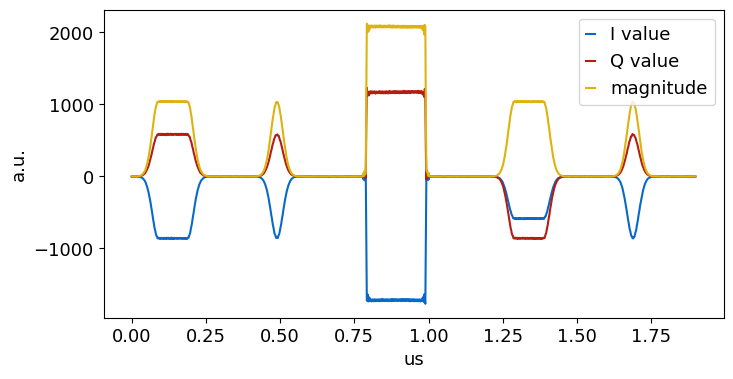

In [22]:
class MultiPulseProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        ramp_len = 0.2
        self.add_gauss(ch=gen_ch, name="ramp", sigma=ramp_len/10, length=ramp_len, even_length=True)
        
        self.add_pulse(ch=gen_ch, name="myflattop", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=0.1,
                       phase=0,
                       gain=1.0, 
                      )

        self.add_pulse(ch=gen_ch, name="mygaus", ro_ch=ro_ch, 
                       style="arb", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0, 
                      )

        self.add_pulse(ch=gen_ch, name="myconst", ro_ch=ro_ch, 
                       style="const", 
                       length=0.2, 
                       freq=cfg['freq'], 
                       phase=0,
                       gain=1.0,
                      )

        self.add_pulse(ch=gen_ch, name="myflattop2", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=0.1,
                       phase=90,
                       gain=1.0, 
                      )

        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)
        # send the config to the dynamic RO
        self.send_readoutconfig(ch=ro_ch, name="myro", t=0)
        
    def _body(self, cfg):
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], ddr4=True)

        self.pulse(ch=cfg['gen_ch'], name="myflattop", t=0)
        self.pulse(ch=cfg['gen_ch'], name="mygaus", t=0.4)
        self.pulse(ch=cfg['gen_ch'], name="myconst", t=0.8)
        self.pulse(ch=cfg['gen_ch'], name="myflattop2", t=1.2)
        self.pulse(ch=cfg['gen_ch'], name="mygaus", t=1.6)
        
config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': FREQ,
          'trig_time': TRIG_TIME,
          'ro_len': 1.9,
         }

prog = MultiPulseProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

#iq_list = prog.acquire_decimated(soc, rounds=10)
iq_list = prog.acquire_decimated(soc)
t = prog.get_time_axis(ro_index=0)

plt.plot(t, iq_list[0][:,0], label="I value")
plt.plot(t, iq_list[0][:,1], label="Q value")
plt.plot(t, np.abs(iq_list[0].dot([1,1j])), label="magnitude")
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us");

In [23]:
class SimpleSweepProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_loop("myloop", self.cfg["steps"])

        self.add_gauss(ch=gen_ch, name="ramp", sigma=cfg['ramp_len']/10, length=cfg['ramp_len'], even_length=True)
        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=cfg['flat_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )

        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)
        # send the config to the dynamic RO
        self.send_readoutconfig(ch=ro_ch, name="myro", t=0)
        
    def _body(self, cfg):
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

  0%|          | 0/1 [00:00<?, ?it/s]

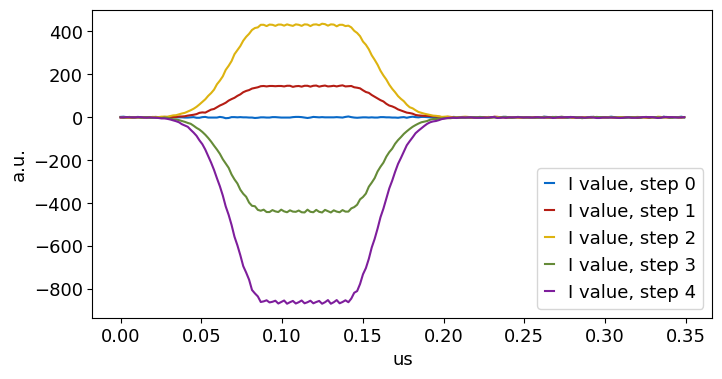

In [24]:
# do a sweep with 5 points and plot decimated
config = {'steps': 5,
          'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': FREQ,
          'trig_time': TRIG_TIME,
          'ro_len': 0.35,
          'flat_len': 0.05,
          'ramp_len': 0.2,
          'phase': QickSweep1D("myloop", -360, 720),
          'gain': QickSweep1D("myloop", 0.0, 1.0)
         }

prog = SimpleSweepProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc)
t = prog.get_time_axis(ro_index=0)

for ii, iq in enumerate(iq_list[0]):
    plt.plot(t, iq[:,0], label="I value, step %d"%(ii))
    # plt.plot(iq[:,1], label="Q value, step %d"%(ii))
    # plt.plot(np.abs(iq.dot([1,1j])), label="mag, step %d"%(ii))
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us");

  0%|          | 0/20100 [00:00<?, ?it/s]

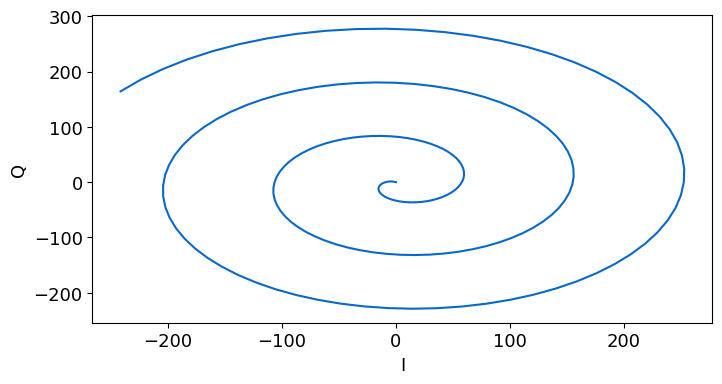

In [26]:
# do a higher-res sweep with acquire()
config['steps']=201
prog = SimpleSweepProgram(soccfg, reps=100, final_delay=1.0, cfg=config)
iq_list = prog.acquire(soc, progress=True)
# plt.plot(np.angle(iq_list[0][0].dot([1,1j]), deg=True))
plt.plot(iq_list[0][0,:,0], iq_list[0][0,:,1])
plt.ylabel("Q")
plt.xlabel("I");

  0%|          | 0/20100 [00:00<?, ?it/s]

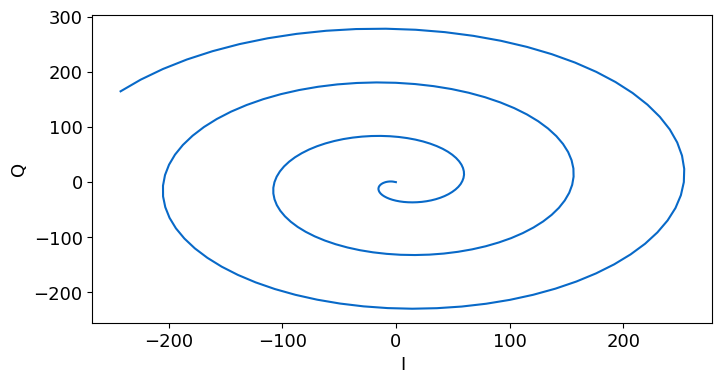

In [28]:
# test that we can dump to a JSON string and restore (for tech support, or AWS sideQICK)
from qick.asm_v2 import AcquireProgramV2
from qick.helpers import progs2json,json2progs
s = progs2json([prog.dump_prog()])

d = json2progs(s)
newprog = AcquireProgramV2(soccfg)
newprog.load_prog(json2progs(s)[0])
iq_list = newprog.acquire(soc)
plt.plot(iq_list[0][0,:,0], iq_list[0][0,:,1])
plt.ylabel("Q")
plt.xlabel("I");

  0%|          | 0/1 [00:00<?, ?it/s]

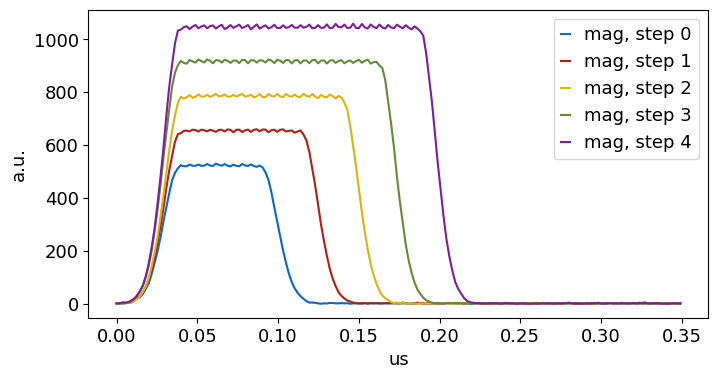

In [30]:
# we can sweep lengths too
config = {'steps': 5,
          'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': FREQ,
          'trig_time': TRIG_TIME,
          'ro_len': 0.35,
          'flat_len': QickSweep1D("myloop", 0.05, 0.15),
          'ramp_len': 0.1,
          'phase': 0,
          'gain': QickSweep1D("myloop", 0.5, 1.0)
         }

prog = SimpleSweepProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc)
t = prog.get_time_axis(ro_index=0)

plt.figure(1)
for ii, iq in enumerate(iq_list[0]):
    # plt.plot(t, iq[:,0], label="I value, step %d"%(ii))
    # plt.plot(t, iq[:,1], label="Q value, step %d"%(ii))
    plt.plot(t, np.abs(iq.dot([1,1j])), label="mag, step %d"%(ii))
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us");

In [31]:
# one flat-top pulse, two user-defined loop levels
class Sweep2DProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_loop("loop1", self.cfg["steps1"]) # this will be the outer loop
        self.add_loop("loop2", self.cfg["steps2"]) # this will be the inner loop
        # the reps loop is always outermost, so the order and the shape of the raw data will be (reps, loop1, loop2)

        self.add_gauss(ch=gen_ch, name="ramp", sigma=cfg['ramp_len']/10, length=cfg['ramp_len'], even_length=True)
        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=cfg['flat_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )

        self.delay(0.5) # give the tProc some time for initial setup
        self.trigger(ddr4=True, mr=True, t=0)

        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)
        # send the config to the dynamic RO
        self.send_readoutconfig(ch=ro_ch, name="myro", t=0)
        
    def _body(self, cfg):
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

  0%|          | 0/500000 [00:00<?, ?it/s]

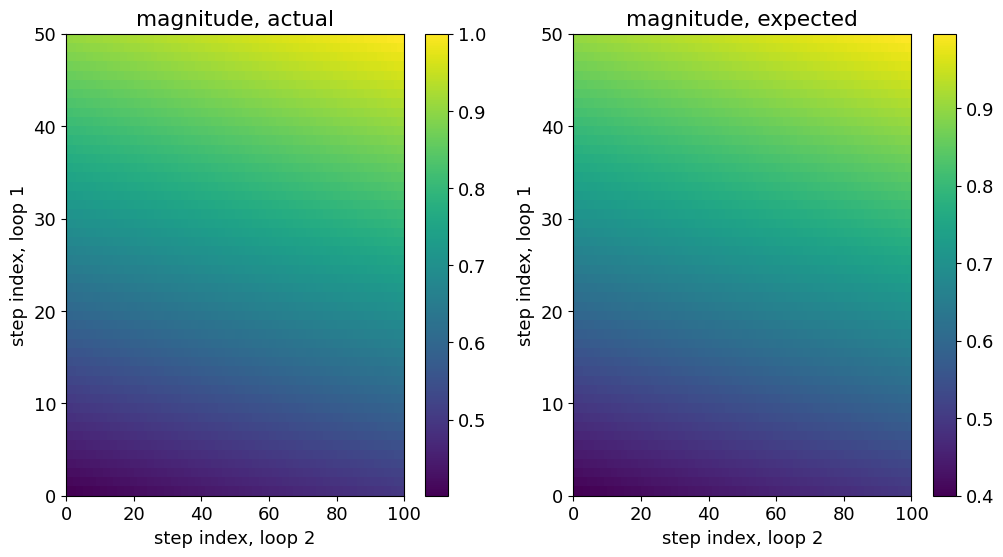

In [33]:
# sweep the gain over both loop levels
# I don't think you would ever want this, exactly, but:
# if you have a multi-D scan where you sweep two durations you may end up with an auto-swept delay that sweeps on both axes
# so it's good to understand that this machinery exists, and works correctly

# see how you can get the grid of sweep values out of the program

config = {'steps1': 50,
          'steps2': 100,
          'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': FREQ,
          'trig_time': TRIG_TIME,
          'ro_len': 0.35,
          'flat_len': 0.05,
          'ramp_len': 0.2,
          'phase': 0,
          # initial value 0.4, sweep by 0.5 in loop1 and by 0.1 in loop2, in other words:
          # the very first shot is 0.4
          # the first loop2 sweep runs from 0.4 to 0.5
          # the last loop2 sweep runs from 0.9 to 1.0
          'gain': 0.4 + QickSpan("loop1", 0.5) + QickSpan("loop2", 0.1)
         }

prog = Sweep2DProgram(soccfg, reps=100, final_delay=1.0, cfg=config)
iq_list = prog.acquire(soc, progress=True)
# plt.plot(np.angle(iq_list[0][0].dot([1,1j]), deg=True))
# plt.plot(iq_list[0][0,0,:,0], iq_list[0][0,0,:,1])
mag = np.abs(iq_list[0][0].dot([1,1j]))

fig, axes = plt.subplots(1,2, figsize=(12,6))
plot = axes[0]
plt.colorbar(plot.pcolormesh(mag/mag.max()))
plot.set_title("magnitude, actual")
plot.set_ylabel("step index, loop 1")
plot.set_xlabel("step index, loop 2");

plot = axes[1]
plt.colorbar(plot.pcolormesh(prog.get_pulse_param('mypulse', 'gain', as_array=True)))
plot.set_title("magnitude, expected")
plot.set_ylabel("step index, loop 1")
plot.set_xlabel("step index, loop 2");

In [34]:
# usually you will use get_pulse_param to query the program for your sweep points
# but get_actual_values() also works (this exists mostly for QICK wrappers like the qcodes driver)
print(prog.get_pulse_param('mypulse', 'gain', as_array=True))
print(config['gain'].get_actual_values(prog.loop_dict))

[[0.39998779 0.40096441 0.40194104  0.49472014 0.49569676 0.49667338]
 [0.41018129 0.41115791 0.41213453  0.50491363 0.50589025 0.50686687]
 [0.42037478 0.4213514  0.42232802  0.51510712 0.51608375 0.51706037]
 
 [0.87908198 0.8800586  0.88103522  0.97381432 0.97479094 0.97576756]
 [0.88927547 0.89025209 0.89122871  0.98400781 0.98498444 0.98596106]
 [0.89946896 0.90044558 0.90142221  0.99420131 0.99517793 0.99615455]]
[[[0.39998779 0.40096441 0.40194104  0.49472014 0.49569676 0.49667338]
  [0.41018129 0.41115791 0.41213453  0.50491363 0.50589025 0.50686687]
  [0.42037478 0.4213514  0.42232802  0.51510712 0.51608375 0.51706037]
  
  [0.87908198 0.8800586  0.88103522  0.97381432 0.97479094 0.97576756]
  [0.88927547 0.89025209 0.89122871  0.98400781 0.98498444 0.98596106]
  [0.89946896 0.90044558 0.90142221  0.99420131 0.99517793 0.99615455]]]


  0%|          | 0/500000 [00:00<?, ?it/s]

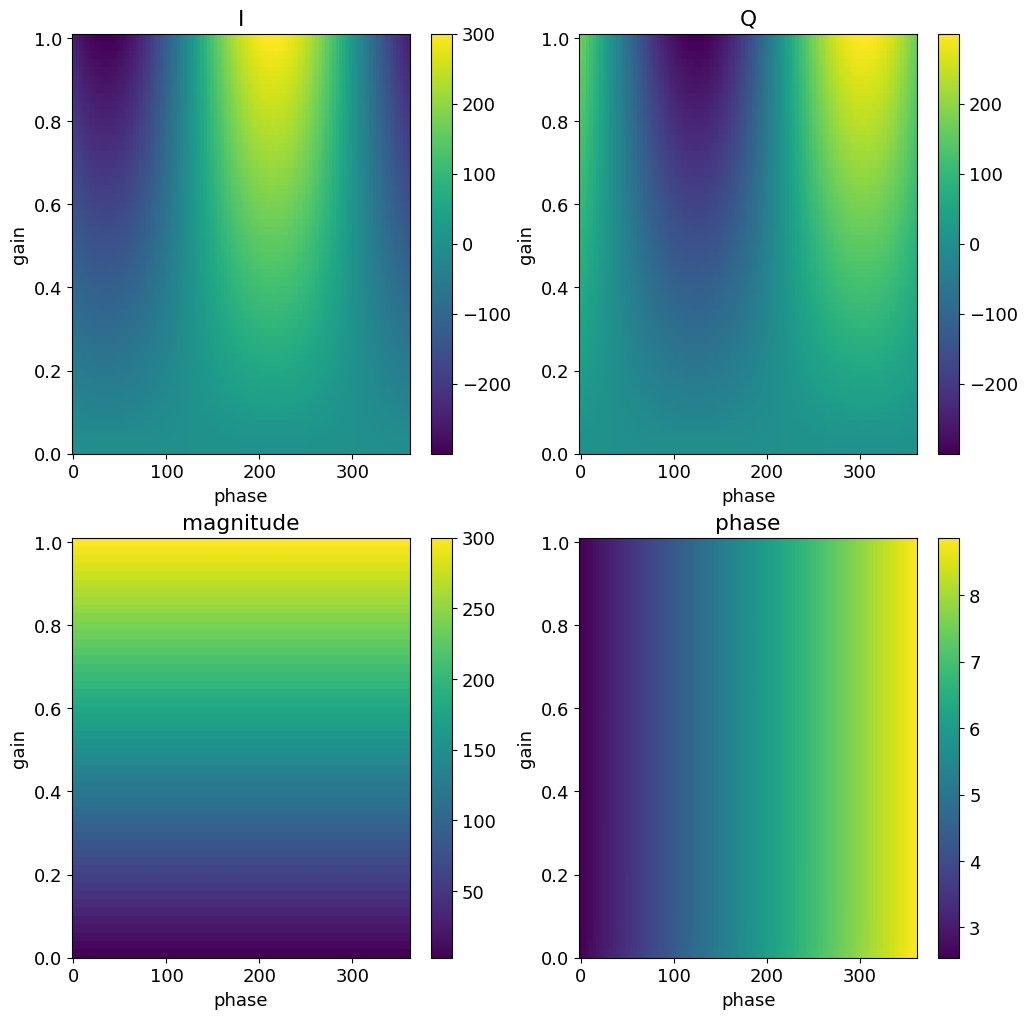

In [37]:
# now do a gain+phase sweep similar to Chao's 07_Sweep_ND demo
config = {'steps1': 50,
          'steps2': 100,
          'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': FREQ,
          'trig_time': TRIG_TIME,
          'ro_len': 0.35,
          'flat_len': 0.05,
          'ramp_len': 0.2,
          'phase': QickSweep1D("loop2", 0, 360),
          'gain': QickSweep1D("loop1", 0.01, 1.0)
         }

prog = Sweep2DProgram(soccfg, reps=100, final_delay=1.0, cfg=config)

iq_list = prog.acquire(soc, progress=True)

fig, axes = plt.subplots(2, 2, figsize=(12,12))

# get the exact values of the parameters, after rounding - this also works for scalars (without as_array), you will just get a float
phases = prog.get_pulse_param("mypulse", "phase", as_array=True)
gains = prog.get_pulse_param("mypulse", "gain", as_array=True)

plot = axes[0,0]
plt.colorbar(plot.pcolormesh(phases, gains, iq_list[0][0,:,:,0]), ax=plot)
plot.set_title("I")
plot.set_ylabel("gain")
plot.set_xlabel("phase")
plot = axes[0,1]
plt.colorbar(plot.pcolormesh(phases, gains, iq_list[0][0,:,:,1]), ax=plot)
plot.set_title("Q")
plot.set_ylabel("gain")
plot.set_xlabel("phase")

plot = axes[1,0]
plt.colorbar(plot.pcolormesh(phases, gains, np.abs(iq_list[0][0].dot([1,1j]))), ax=plot)
plot.set_title("magnitude")
plot.set_ylabel("gain")
plot.set_xlabel("phase")

plot = axes[1,1]
plt.colorbar(plot.pcolormesh(phases, gains, np.unwrap(np.angle(iq_list[0][0].dot([1,1j])), axis=1)), ax=plot)
plot.set_title("phase")
plot.set_ylabel("gain")
plot.set_xlabel("phase");